In [1]:
from substra import Client
import substra 
import pathlib
from flamby.datasets import fed_tcga_brca




MODE = "subprocess"

# Create the substra clients
# clients = [
# 		 substra.Client(url='https://fl-api.b2ai-staging.b2ai-voice.org/', token='03da14857bc494c06af6b21cbf4ad6e4430de3bd', backend_type=MODE), # Bridge2ai
# 		substra.Client(url='https://fl-api.wcm-staging.b2ai-voice.org/', token='5979f77ee6001c6f0846cd33c72f484c24573342', backend_type=MODE), # WCM, 
#         substra.Client(url='https://fl-api.usf-staging.b2ai-voice.org/', token='d3dffc039cd47b8eb2757de2f8786db3cb8fbaa8', backend_type=MODE) # USF
# ]
data_provider_clients = [Client(backend_type=MODE) for _ in range(fed_tcga_brca.NUM_CLIENTS)]
data_provider_clients = {client.organization_info().organization_id: client for client in data_provider_clients}
# print([client.organization_info().organization_id for client in clients])
# data_provider_clients = {
#     "MyOrg1MSP": clients[0],
#     "MyOrg2MSP": clients[1],
#     "MyOrg3MSP": clients[2]
# }

# algo_provider_client = substra.Client(url='https://fl-api.b2ai-dev.b2ai-voice.org/', token='5ecd6c2e8d027583c9cb97808e2189e0afb6b43e', backend_type=MODE) # Bridge2ai
algo_provider_client = Client(backend_type=MODE)




# Store their IDs
DATA_PROVIDER_ORGS_ID = list(data_provider_clients.keys())
print(data_provider_clients)
print(DATA_PROVIDER_ORGS_ID[1:3])
print(algo_provider_client)

# The org id on which your computation tasks are registered
ALGO_ORG_ID = "MyOrg1MSP"

{'MyOrg1MSP': <substra.sdk.client.Client object at 0x7fa89d6a02b0>, 'MyOrg2MSP': <substra.sdk.client.Client object at 0x7fa89dd176a0>, 'MyOrg3MSP': <substra.sdk.client.Client object at 0x7fa89e810a00>, 'MyOrg4MSP': <substra.sdk.client.Client object at 0x7fa88caa1c70>, 'MyOrg5MSP': <substra.sdk.client.Client object at 0x7fa88caa1b80>, 'MyOrg6MSP': <substra.sdk.client.Client object at 0x7fa88caa8700>}
['MyOrg2MSP', 'MyOrg3MSP']


Create Substra Clients for Each org

In [2]:
import pathlib

from substra.sdk.schemas import DatasetSpec
from substra.sdk.schemas import DataSampleSpec
from substra.sdk.schemas import Permissions

assets_directory = pathlib.Path.cwd() / "integration/Substra/assets"
print(assets_directory)
empty_path = assets_directory / "empty_datasamples"

permissions_dataset = Permissions(public=True, authorized_ids=["Bridge2AI", 'WCM', 'USF'])


train_dataset_keys = {}
test_dataset_keys = {}

train_datasample_keys = {}
test_datasample_keys = {}
print(DATA_PROVIDER_ORGS_ID)
print(data_provider_clients)
for ind, org_id in enumerate(DATA_PROVIDER_ORGS_ID):
    print(org_id)
    ind += 1
    print(ind)
    client = data_provider_clients[org_id]
    


    # DatasetSpec is the specification of a dataset. It makes sure every field
    # is well defined, and that our dataset is ready to be registered.
    # The real dataset object is created in the add_dataset method.

    dataset = DatasetSpec(
        name="FLamby",
        type="torchDataset",
        data_opener=assets_directory / "dataset" / f"opener_train_MyOrg{ind}MSP.py",
        description=assets_directory / "dataset" / "description.md",
        permissions=permissions_dataset,
        logs_permission=permissions_dataset,
    )

    # Add the dataset to the client to provide access to the opener in each organization.
    train_dataset_key = client.add_dataset(dataset)
    
    print(client)

    assert train_dataset_key, "Missing data manager key"

    train_dataset_keys[org_id] = train_dataset_key
    print(client)
    # Add the training data on each organization.
    data_sample = DataSampleSpec(
        data_manager_keys=[train_dataset_key],
        test_only=False,
        path=empty_path,
    )
    #print(client.list_dataset())
    train_datasample_key = client.add_data_sample(
        data_sample,
        local=True,
    )

    train_datasample_keys[org_id] = train_datasample_key

    # Add the testing data.

    test_dataset_key = client.add_dataset(
        DatasetSpec(
            name="FLamby",
            type="torchDataset",
            data_opener=assets_directory / "dataset" / f"opener_test_MyOrg{ind}MSP.py",
            description=assets_directory / "dataset" / "description.md",
            permissions=permissions_dataset,
            logs_permission=permissions_dataset,
        )
    )
    assert test_dataset_key, "Missing data manager key"
    test_dataset_keys[org_id] = test_dataset_key

    data_sample = DataSampleSpec(
        data_manager_keys=[test_dataset_key],
        test_only=True,
        path=empty_path,
    )
    test_datasample_key = client.add_data_sample(
        data_sample,
        local=True,
        
    )

    test_datasample_keys[org_id] = test_datasample_key


    

/Users/Stefan/Dropbox/Computer_Science/Owkin_Internship/FLamby/integration/Substra/assets
['MyOrg1MSP', 'MyOrg2MSP', 'MyOrg3MSP', 'MyOrg4MSP', 'MyOrg5MSP', 'MyOrg6MSP']
{'MyOrg1MSP': <substra.sdk.client.Client object at 0x7fa89d6a02b0>, 'MyOrg2MSP': <substra.sdk.client.Client object at 0x7fa89dd176a0>, 'MyOrg3MSP': <substra.sdk.client.Client object at 0x7fa89e810a00>, 'MyOrg4MSP': <substra.sdk.client.Client object at 0x7fa88caa1c70>, 'MyOrg5MSP': <substra.sdk.client.Client object at 0x7fa88caa1b80>, 'MyOrg6MSP': <substra.sdk.client.Client object at 0x7fa88caa8700>}
MyOrg1MSP
1
MyOrg2MSP
2
MyOrg3MSP
3
MyOrg4MSP
4
MyOrg5MSP
5
MyOrg6MSP
6


Register Datasets and set permissions

In [3]:
import numpy as np

from torch.utils import data

from substrafl.dependency import Dependency


def tgca_brca_metric(datasamples, predictions_path):

    config = datasamples

    dataset = fed_tcga_brca.FedTcgaBrca(**config)
    dataloader = data.DataLoader(dataset, batch_size=len(dataset))

    y_true =  next(iter(dataloader))[1]
    y_pred = np.load(predictions_path)

    return float(fed_tcga_brca.metric(y_true, y_pred))

# The Dependency object is instantiated in order to install the right libraries in
# the Python environment of each organization.
# The local dependencies are local packages to be installed using the command `pip install -e .`.
# Flamby is a local dependency. We put as argument the path to the `setup.py` file.
print(pathlib.Path.cwd())
metric_deps = Dependency(pypi_dependencies=["torch==1.11.0","numpy==1.23.1"],
                         local_dependencies=[pathlib.Path.cwd()], # Flamby dependency
                        )
permissions_metric = Permissions(public = True, authorized_ids = DATA_PROVIDER_ORGS_ID)

from importlib.metadata import version
print(version('substrafl'))





/Users/Stefan/Dropbox/Computer_Science/Owkin_Internship/FLamby
0.39.0


Specify how much data to train

In [4]:
from substrafl.index_generator import NpIndexGenerator

NUM_UPDATES = 16
SEED = 42

index_generator = NpIndexGenerator(
    batch_size=fed_tcga_brca.BATCH_SIZE,
    num_updates=NUM_UPDATES,
)

In [5]:
class TorchDataset(fed_tcga_brca.FedTcgaBrca):

    def __init__(self, datasamples, is_inference):
        config = datasamples
        super().__init__(**config)

Defines the Substra Algo

In [6]:
import torch

from substrafl.algorithms.pytorch import TorchFedAvgAlgo

model = fed_tcga_brca.Baseline()

class MyAlgo(TorchFedAvgAlgo):
    def __init__(self):
        super().__init__(
            model=model,
            criterion=fed_tcga_brca.BaselineLoss(),
            optimizer=fed_tcga_brca.Optimizer(model.parameters(), lr=fed_tcga_brca.LR),
            index_generator=index_generator,
            dataset=TorchDataset,
            seed=SEED,
        )

    def _local_predict(self, predict_dataset: torch.utils.data.Dataset, predictions_path):

        batch_size = self._index_generator.batch_size
        predict_loader = torch.utils.data.DataLoader(predict_dataset, batch_size=batch_size)

        self._model.eval()

        # The output dimension of the model is of size (1,)
        predictions = torch.zeros((len(predict_dataset), 1))

        with torch.inference_mode():
            for i, (x, _) in enumerate(predict_loader):
                x = x.to(self._device)
                predictions[i * batch_size: (i+1) * batch_size] = self._model(x)

        predictions = predictions.cpu().detach()
        self._save_predictions(predictions, predictions_path)

Pick FL Strategy (using Fed Avg)

In [7]:
from substrafl.strategies import FedAvg



strategy = FedAvg(algo=MyAlgo())


Choose where to train and where to aggregate

In [8]:
from substrafl.nodes import TrainDataNode
from substrafl.nodes import AggregationNode


aggregation_node = AggregationNode('MyOrg1MSP')
print(aggregation_node)

train_data_nodes = list()

for org_id in DATA_PROVIDER_ORGS_ID:

    # Create the Train Data Node (or training task) and save it in a list
    train_data_node = TrainDataNode(
        organization_id=org_id,
        data_manager_key=train_dataset_keys[org_id],
        data_sample_keys=[train_datasample_keys[org_id]],
    )
    train_data_nodes.append(train_data_node)

    



Choose where and when to test

In [9]:
from substrafl.nodes import TestDataNode
from substrafl.evaluation_strategy import EvaluationStrategy





test_data_nodes = list()
print(test_datasample_keys)

for org_id in DATA_PROVIDER_ORGS_ID:
    print(org_id)
    print(test_dataset_keys[org_id])

    # Create the Test Data Node (or testing task) and save it in a list
    test_data_node = TestDataNode(
        organization_id=org_id,
        data_manager_key=test_dataset_keys[org_id],
        test_data_sample_keys=[test_datasample_keys[org_id]],
        metric_functions={"Accuracy": tgca_brca_metric},
    )
    test_data_nodes.append(test_data_node)

# Test at the end of every round
print(test_data_nodes)
my_eval_strategy = EvaluationStrategy(test_data_nodes=test_data_nodes, eval_rounds=[1])
from importlib.metadata import version
print(version('substra'))

{'MyOrg1MSP': '5dc5f923-cbc5-4c26-96b6-7dc5de39b188', 'MyOrg2MSP': 'db81be67-0941-4017-8350-ec1bc67d1ae2', 'MyOrg3MSP': 'd4a21cd9-6f53-48f3-8371-7b8d5a5090b6', 'MyOrg4MSP': '086337c4-2ea0-4ff4-888d-3a659bf30b30', 'MyOrg5MSP': '5f5f0102-9ef0-483f-b6f5-49666767f0ef', 'MyOrg6MSP': 'ec55b48e-cbfe-4f7b-aad9-1fb1084f1d76'}
MyOrg1MSP
46abb324-b206-4d20-a061-fb7f0b3d256a
MyOrg2MSP
6d1c5c74-5d69-4721-9641-18501f1757a2
MyOrg3MSP
19fc3e48-2514-4472-8204-07c2af363d96
MyOrg4MSP
b7cc2930-035d-4887-be12-83de089301ea
MyOrg5MSP
5f074d5a-15d9-47ba-bcca-5df4354b2214
MyOrg6MSP
59731633-351e-490f-95b3-fc1e1b3d393c
[<substrafl.nodes.test_data_node.TestDataNode object at 0x7fa88cf54fa0>, <substrafl.nodes.test_data_node.TestDataNode object at 0x7fa88cf54fd0>, <substrafl.nodes.test_data_node.TestDataNode object at 0x7fa88cf74820>, <substrafl.nodes.test_data_node.TestDataNode object at 0x7fa88cf74670>, <substrafl.nodes.test_data_node.TestDataNode object at 0x7fa88cf745e0>, <substrafl.nodes.test_data_node.TestDa

Performs the Experiment

In [10]:
from substrafl.experiment import execute_experiment

# Number of time to apply the compute plan.
NUM_ROUNDS = 3

# The Dependency object is instantiated in order to install the right libraries in
# the Python environment of each organization.
# The local dependencies are local packages to be installed using the command `pip install -e .`.
# Flamby is a local dependency. We put as argument the path to the `setup.py` file.

algo_deps = Dependency(pypi_dependencies=["torch==1.11.0"], local_dependencies=[pathlib.Path.cwd()])
#algo_deps = Dependency(pypi_dependencies=["torch==1.11.0"])

compute_plan = execute_experiment(
    client=algo_provider_client,
    strategy=strategy,
    train_data_nodes=train_data_nodes,
    evaluation_strategy=my_eval_strategy,
    aggregation_node=aggregation_node,
    num_rounds=NUM_ROUNDS,
    experiment_folder= str(pathlib.Path.cwd() / "experiment_summaries"),
    dependencies=algo_deps,
)

2023-09-08 15:01:26,181 - INFO - Building the compute plan.
2023-09-08 15:01:26,201 - INFO - Registering the functions to Substra.
2023-09-08 15:01:26,445 - INFO - Registering the compute plan to Substra.
2023-09-08 15:01:26,448 - INFO - Experiment summary saved to /Users/Stefan/Dropbox/Computer_Science/Owkin_Internship/FLamby/experiment_summaries/2023_09_08_15_01_26_65e24a72-7491-4e37-9c59-e9fc0e72bceb.json


Compute plan progress:   0%|          | 0/45 [00:00<?, ?it/s]

/Users/Stefan/opt/miniconda3/envs/flamby/lib/python3.8/site-packages/substra/sdk/backends/local/backend.py:601: UserWarning: `transient=True` is ignored in local mode
  warnings.warn("`transient=True` is ignored in local mode", stacklevel=1)


Have you taken the time to read and accept the data terms on the original website, available at the following link: https://gdc.cancer.gov/access-data/data-access-processes-and-tools ? | (y/n)




NameError: name 'compute_plan' is not defined

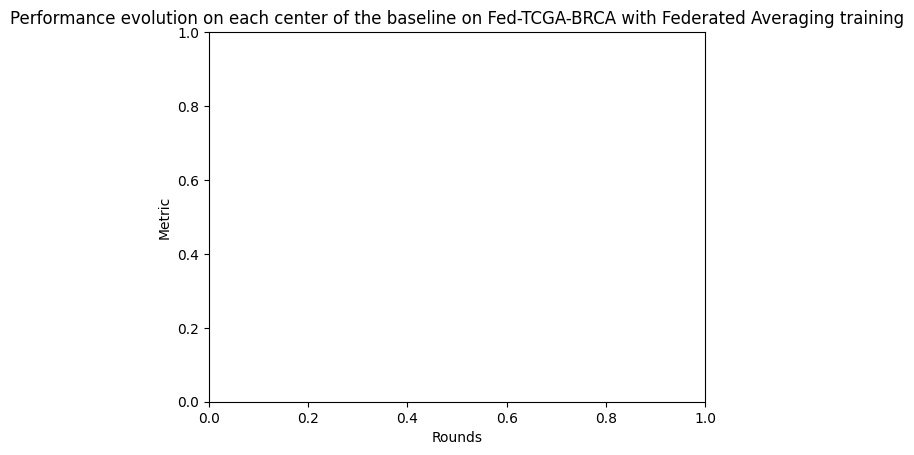

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.title("Performance evolution on each center of the baseline on Fed-TCGA-BRCA with Federated Averaging training")
plt.xlabel("Rounds")
plt.ylabel("Metric")

performance_df = pd.DataFrame(client.get_performances(compute_plan.key).dict())

for i, id in enumerate(DATA_PROVIDER_ORGS_ID):
    df = performance_df.query(f"worker == '{id}'")
    plt.plot(df["round_idx"], df["performance"], label=f"Client {i} ({id})")

plt.legend(loc=(1.1, 0.3), title="Test set")
plt.show()